<a href="https://colab.research.google.com/github/Cybertocks/Show-attend-and-tell/blob/master/attention_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

In [0]:
os.chdir('/content/Image-inf')

In [0]:
!git init

Initialized empty Git repository in /content/Image-inf/.git/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip -q install voila
!pip -q jupyter serverextension enable voila --sys-prefix

     |████████████████████████████████| 5.9MB 16.5MB/s 
     |████████████████████████████████| 921kB 47.8MB/s 
     |████████████████████████████████| 184kB 65.0MB/s 
ERROR: qtconsole 4.7.2 has requirement pyzmq>=17.1, but you'll have pyzmq 17.0.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: unknown command "jupyter"


In [0]:
import dill as pickler
from fastai import *
from fastai.vision import *
from torchvision import transforms
pickler._dill._reverse_typemap['ClassType'] = type

In [0]:
!mkdir models

In [0]:
!cp '/content/drive/My Drive/Image_Captioning/models/vocab_coco.pkl' '/content/models/vocab_coco.pkl'

In [0]:
!cp '/content/drive/My Drive/Image_Captioning/models/models/mygoodmodel_coco.pth' '/content/models/mygoodmodel_coco.pth'

In [0]:
!cp '/content/drive/My Drive/Image_Captioning/models/coco_databunch.pkl' '/content/models/coco_databunch.pkl'

In [0]:
!cp '/content/drive/My Drive/Image_Captioning/models/coco_beam_searcher.pkl' '/content/models/coco_beam_search.pkl'

In [0]:
!cp '/content/drive/My Drive/Image_Captioning/models/decoder.pkl' '/content/models/decoder.pkl'

In [0]:
gpu = torch.device('cuda:0')

In [0]:
vocab = pickle.load(open('models/vocab_coco.pkl', 'rb'))

In [0]:
n_layers, attn_size = 1, 1000
sz = 224

In [0]:
# last layers of resnet
def fc_layer(in_, out, p=0.1):
  return nn.Sequential(
  Flatten(),
  nn.Linear(in_, out),
  nn.Dropout(p),
  )

In [0]:
class Encoder(nn.Module):
    def __init__(self, device, dec_hidden_state_size, dec_layers, filter_width, num_filters):
        super().__init__()
        # Visual Encoder
        self.device = device
        self.base_network = nn.Sequential(*list(models.resnet101(pretrained=True).children())[:-2])
        self.freeze_base_network()
        self.concatPool = AdaptiveConcatPool2d(sz=1)
        self.adaptivePool = nn.AdaptiveAvgPool2d((filter_width, filter_width))
        self.filter_width = filter_width
        
        self.output_layers = nn.ModuleList([
            fc_layer(2*num_filters, dec_hidden_state_size) for _ in range(dec_layers)
        ])
          
    def forward(self, inp):
        #pdb.set_trace()
        enc_output = self.base_network(inp)
        annotation_vecs = self.adaptivePool(enc_output).view(enc_output.size(0), enc_output.size(1), -1)
        enc_output = self.concatPool(enc_output)
        
        dec_init_hidden_states = [MLP_layer(enc_output) for MLP_layer in self.output_layers]
        
        return torch.stack(dec_init_hidden_states, dim = 0), annotation_vecs.transpose(1, 2)
    
    def freeze_base_network(self):
        for layer in self.base_network:
            requires_grad(layer, False)
            
    def fine_tune(self, from_block=-1):
        for layer in self.base_network[from_block:]:
            requires_grad(layer, True)

In [0]:
class VisualAttention(nn.Module):
    def __init__(self, num_filters, dec_dim, att_dim):
        super().__init__()
        self.attend_annot_vec = nn.Linear(num_filters, att_dim)
        self.attend_dec_hidden= nn.Linear(dec_dim, att_dim)
        self.f_att = nn.Linear(att_dim, 1)  # Equation (4) in Xu et al. (2015)
        
    def forward(self, annotation_vecs, dec_hid_state):
        #pdb.set_trace()
        attended_annotation_vecs = self.attend_annot_vec(annotation_vecs)
        attended_dec_hid_state   = self.attend_dec_hidden(dec_hid_state)
        e = self.f_att(F.relu(attended_annotation_vecs + attended_dec_hid_state.unsqueeze(1))).squeeze(2)  # Eq. 4
        alphas = F.softmax(e, dim=1)  # Equation (5) in Xu et al. (2015)
        context_vec = (annotation_vecs * alphas.unsqueeze(2)).sum(1)  # Equations (13)
        
        return context_vec, alphas

In [0]:
class Decoder(nn.Module):
    def __init__(self, device, filter_width, num_filters, vocab_size, emb_sz, out_seqlen, n_layers=3, prob_teach_forcing=1, p_drop=0.3):
        super().__init__()
        self.n_layers, self.out_seqlen = n_layers, out_seqlen
        self.filter_width = filter_width
        self.num_filters = num_filters
        self.device = device  
        
        # Encoder
        self.encoder = Encoder(device, emb_sz, n_layers, filter_width, num_filters)
        
        # Attention
        self.att = VisualAttention(num_filters, emb_sz, 500)
        
        # Decoder
        self.emb = nn.Embedding(vocab_size, emb_sz) #create_emb(wordvecs, itos, emb_sz)
        self.rnn_dec = nn.GRU(num_filters + emb_sz, emb_sz, num_layers=n_layers, dropout=0 if n_layers == 1 else p_drop)  # square to enable weight tying
        self.out_drop = nn.Dropout(p_drop)
        self.out = nn.Linear(emb_sz, vocab_size)
        self.out.weight.data = self.emb.weight.data
        self.f_b = nn.Linear(emb_sz, num_filters)  # Section 4.2.1 in Xu et al. (2015)
        
        self.prob_teach_forcing = prob_teach_forcing
        self.initializer()
        
    def initializer(self):
        self.emb.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, x, y=None):
        #pdb.set_trace()
        h, annotation_vecs = self.encode(x)

        dec_inp = torch.zeros(h.size(1), requires_grad=False).long()
        dec_inp = dec_inp.to(self.device)
        res = []
        alphas = []
        
        for i in range(self.out_seqlen):
            #pdb.set_trace()
            dec_output, h, alpha = self.decode_step(dec_inp, h, annotation_vecs)
            res.append(dec_output)
            alphas.append(alpha)
            
            if (dec_inp == 1).all() or (y is not None and i >= len(y)):
                break            
            # teacher forcing
            elif y is not None and (self.prob_teach_forcing > 0) and (random.random() < self.prob_teach_forcing):
                dec_inp = y[i].to(self.device)
            else:
                dec_inp = dec_output.data.max(1)[1]  # [1] to get argmax
        
        return torch.stack(res), torch.stack(alphas)
    
    def encode(self, x):
        return self.encoder(x.to(self.device))
    
    def decode_step(self, dec_inp, h, annotation_vecs):
        #pdb.set_trace()
        context_vec, alpha = self.att(annotation_vecs, h[-1])
        beta = torch.sigmoid(self.f_b(h[-1]))
        context_vec = beta * context_vec  # Section 4.2.1 in Xu et al. (2015)
        
        emb_inp = self.emb(dec_inp).unsqueeze(0)  # adds unit axis at beginning so that rnn 'loops' once

        output, h = self.rnn_dec(torch.cat([emb_inp, context_vec.unsqueeze(0)], dim=2), h)
        output = self.out(self.out_drop(output[0]))

        # return F.log_softmax(output, dim=1), h, alpha
        return F.log_softmax(output, dim=1), h, alpha

In [18]:
decoder = Decoder(gpu, 7, 2048, len(vocab.itos), 1000, 50, n_layers, p_drop=0.2)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
pickler._dill._reverse_typemap['ClassType'] = type

In [0]:
decoder = pickler.load(open('models/coco_beam_search.pkl', 'rb'))

In [0]:
# @dataclass
# class TeacherForcingCallback(Callback):
#   def __init__(self, learn, decay_epochs=45):
#     super().__init__()
#     self.learn = learn
#     self.decay_iterations = decay_epochs * len(self.learn.data.train_ds) // self.learn.data.batch_size

#   def on_batch_begin(self, iteration, **kwargs):
#     slef.learn.model.prob_teach_forcing = (self.decay_iterations-iteration) * 1/self.decay_iterations if iteration < self.decay_iterations else 0

In [0]:
# def ImageCaptionLoss(pred, target, lamb=1):
#   pred, alphas = pred
#   seqlen, bs = target.size()
#   seqlen_pred, bs_pred, n_probs = pred.size()

#   # we need to pad if target seqlen is larger than prediction seqlen
#   if seqlen > seqlen_pred:
#     pred = F.pad(pred, (0,0,0,0,0,seqlen-seqlen_pred))

#   # but we only compare until the seqlen of the target
#   pred = pred[:seqlen]
  
#   # cross_entropy can't handle rank 3 tensors currently, we need to flatten
#   loss = F.nll_loss(pred.contiguous().view(-1, n_probs), target.contiguous().view(-1))
  
#   # See section 4.2.1 "Doubly stocastic attention"
#   penalty = ((1. - alphas.sum(0)) ** 2.).mean()

#   return loss + lamb * penalty

In [0]:
# opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [0]:
# dataBunch = pickler.load(open('models/coco_databunch.pkl', 'rb'))

In [0]:
# learn = Learner(data=dataBunch, model=to_device(decoder, gpu), model_dir='./models/')

In [0]:
# learn = learn.load('mygoodmodel_coco')

In [0]:
class HypothesisNode():
    """ Hypothesis Node class for performing Beam Search """
    def __init__(self, sequence, log_prob, hidden_state, alphas):
        """HypothesisNode constructur
        
        Args:
          sequence: A sequence of tokens
          log_prob: The log of the probability of this sequence
          hidden_state: The hidden state of the Decoder RNN after decoding the last token in the sequence
        """
        self._seq = sequence
        self._alphas = alphas
        self._log_prob = log_prob
        self._h = hidden_state
    
    @property
    def last_tok(self):
        """
        Returns:
          The last token in the sequence
        """
        return self._seq[-1]
        
    def update(self, tok, log_prob, new_h, new_alpha):
        """
        Updates the sequence with a new token and returns a new Hypothesis Node
        Args:
          tok: The new token that is appended to the sequence
          log_prob: The log of the probability ot this token
          new_h: The new hidden state of the Decoder RNN after this token
        
        Returns:
          An Hypothesis Node with the updated sequence, log probability and hidden state
        """
        return HypothesisNode(self._seq + [tok], self._log_prob + log_prob, new_h, self._alphas + new_alpha)
    
    def __str__(self):
        return ('Hyp(log_p = %4f,\t seq = %s)' % (self._log_prob, vocab.textify([t.item()for t in self._seq])))

In [0]:
class BeamSearch():
    """ Performs BeamSearch for seq2seq decoding or Image captioning """
    def __init__(self, enc_model, dec_model, beam_width=5, num_results=1, max_len=30, device=torch.device('cuda:0')):
        """BeamSearch object constructor
        Args:
          enc_model: A seq2seq encoder or cnn for image captioning
          dec_model: A RNN decoder model
          beam_width: int, the number of hypotheses to remember in each iteration
          max_len: int, the longest possible sequence
        """
        self._device = device
        self._enc_model = enc_model
        self._dec_model = dec_model
        self._beam_width = beam_width
        self._num_results = num_results
        self._max_len = max_len
        self._start_tok = 0
        self._end_tok   = 1
        self._annotation_vecs = None
        
    def __call__(self, img, verbose=False):
        """Performs the Beam search
        Args:
          img: the image to be annotated, torch tensor with 3 color channels
          verbose: bool, allows printing the intermediate hypotheses for better understanding
        
        Returns:
          The 'beam_width' most probable sentences
        """
        img = img.unsqueeze(0)
        h, annotation_vecs = self._enc_model(img)
        self._annotation_vecs = annotation_vecs
        
        hyps = [HypothesisNode([torch.zeros(1, requires_grad=False).long().to(self._device)], 0, h, [])]
        results = []
        
        step = 0
        width = self._beam_width
        while width > 0 and step < self._max_len:
            if verbose: print("\n Step: ",step)
            new_hyps = []
            for h in hyps:
                new_hyps.extend(self.get_next_hypotheses(h, width))
            
            new_hyps = sorted(new_hyps, key= lambda x: x._log_prob, reverse=True)
            if verbose: self.print_hypotheses(new_hyps, "Before narrowing:")
                
            hyps = []
            for h in new_hyps[:width]:
                if h.last_tok == self._end_tok:
                    results.append(h)
                    width = width - 1
                else:
                    hyps.append(h)
            
            if verbose: 
                self.print_hypotheses(hyps, "After narrowing:")
                self.print_hypotheses(results, "Results:")
                
            step += 1
         
        results.extend(hyps[:width])
        results = sorted(results, key=lambda x: x._log_prob/len(x._seq), reverse=True)
        
        if verbose: self.print_hypotheses(results, "Final:")
        
        if self._num_results == 1:
            return ([t.item() for t in results[0]._seq[1:-1]], torch.stack(results[0]._alphas))
        else:
            return [([t.item() for t in r._seq[1:-1]], torch.stack(r._alphas)) for r in results[:self._num_results]]
        
    def get_next_hypotheses(self, hyp, k):
        """Calculates the next 'beam_width' hypotheses given a Hypothesis Node
        Args:
          hyp: an Hypothesis Node containing a sequence, a log probability and a Decoder RNN hidden state
          k: the number of hypotheses to calculate
        Returns:
          A list with the 'beam_width' most probable sequences/Hypothesis Nodes
        """

        dec_outp, h, alphas = self._dec_model(hyp.last_tok, hyp._h, self._annotation_vecs)

        top_k_log_probs, top_k_toks = dec_outp.topk(k, dim=1)
        return [hyp.update(top_k_toks[0][i].unsqueeze(0), top_k_log_probs[0][i], h, list(alphas)) for i in range(k)]
    
    def print_hypotheses(self, hyps, description):
        print(description)
        for h in hyps:
            print(h)

In [0]:
# from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
from matplotlib.patheffects import Stroke, Normal
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# the functions fig2data and fig2img are taken from 
# http://www.icare.univ-lille1.fr/tutorials/convert_a_matplotlib_figure
# Deprecation errors have been fixed

def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw ( )
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring( fig.canvas.tostring_argb(), dtype=np.uint8 )
    buf.shape = ( w, h,4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data ( fig )
    w, h, d = buf.shape
    return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_outline(matplt_plot_obj, lw):
    matplt_plot_obj.set_path_effects([Stroke(linewidth=lw, foreground='black'), Normal()])

def show_img(im, figsize=None, ax=None, alpha=1, cmap=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap=cmap)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def visualize_attention(im, pred, alphas, denorm, vocab, att_size=7, thresh=0., sz=224, return_fig_as_PIL_image=False):
    cap_len = len(pred)
    alphas = alphas.view(-1,1,  att_size, att_size).cpu().data.numpy()
    alphas = np.maximum(thresh, alphas)
    alphas -= alphas.min()
    alphas /= alphas.max()
 
    figure, axes = plt.subplots(cap_len//5 + 1,5, figsize=(12,8))
 
    for i, ax in enumerate(axes.flat):
        if i <= cap_len:
            ax = show_img(denorm(im), ax=ax)
            if i > 0:
                mask = np.array(PIL.Image.fromarray(alphas[i - 1,0]).resize((sz,sz)))
                blurred_mask = gaussian_filter(mask, sigma=8)
                show_img(blurred_mask, ax=ax, alpha=0.5, cmap='afmhot')
                draw_text(ax, (0,0), vocab.itos[pred[i - 1]])
        else:
            ax.axis('off')
    plt.tight_layout()

    if return_fig_as_PIL_image:
        return fig2img(figure)

In [0]:
beam_width = 5

In [0]:
beam_search = pickler.load(open('models/coco_beam_search.pkl', 'rb'))

In [0]:
# url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRlY-UJ0r6nbUXRSaaQuAha-mmuCQfSxacNBsjBP6mM-mFNE14x&usqp=CAU'

In [0]:
# !mkdir images

In [50]:
download_url(url, 'images/rand2.jpg', overwrite=True)

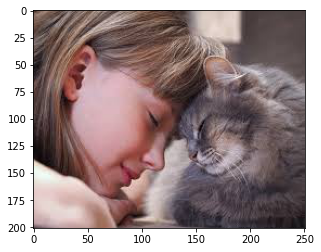

In [0]:
# plt.imshow(open_image('images/rand2.jpg').data.float().permute(1,2,0))

In [0]:
# im = open_image('images/rand2.jpg').data.float()

In [0]:
# inv_norm = transforms.Normalize(
#     mean =  [-0.5238/0.3159, -0.5003/0.3091, -0.4718/0.3216],
#     std = [1/0.3159, 1/0.3091, 1/0.3216]
# )

# denorm = transforms.Compose([
#                             inv_norm,
#                             # make the image PIL readable
#                             transforms.functional.to_pil_image
# ])

a little girl laying on a bed with a teddy bear .


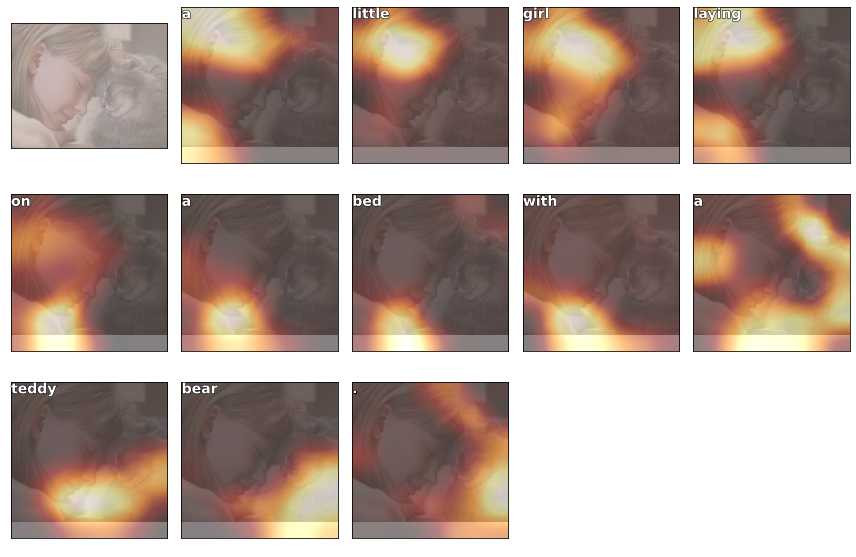

In [54]:

# results = beam_search(im);
# x = vocab.textify(results[0])
# print(x)
# visualize_attention(im, results[0], results[1], denorm, vocab, att_size=7, sz=sz, thresh=0.02)

In [0]:
from ipywidgets import widgets, VBox
from types import SimpleNamespace
import warnings
warnings. filterwarnings('ignore')

In [0]:
defaults.use_cuda = True
text = widgets.Text()
output = widgets.Output()
output_attn = widgets.Output()
label = widgets.Label()
caption_lbl = widgets.Label()
attend = widgets.Button(description='Caption eet!!')

In [0]:
def on_click(change):
  # if len(upload.data)!=0:
  if len(upload_btn.data)!=0:
    # img = upload.data[-1]
    img = open_image(upload_btn.data[-1])
    output.clear_output()
    with output:
      display(img)
    results = beam_search(img.data);
    pred_caption = vocab.textify(results[0])
    caption_lbl.value = pred_caption
    output_attn.clear_output()
    with output_attn:
      visualize_attention(img.data, results[0], results[1], denorm, vocab, att_size=7, sz=sz, thresh=0.02)
  else: print('Please upload an image')

attend.on_click(on_click)

In [0]:
upload = SimpleNamespace(data=[open_image('images/rand2.jpg')])

In [0]:
upload_btn = widgets.FileUpload()

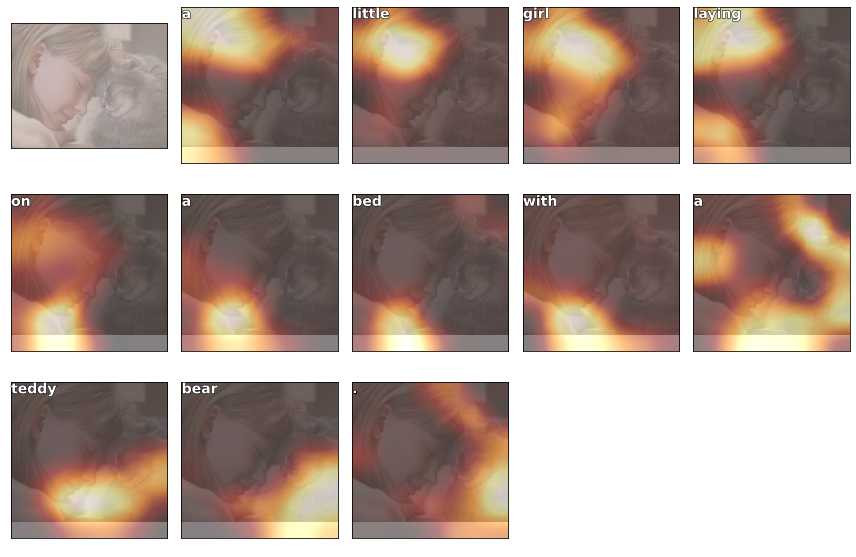

In [284]:
display(VBox([widgets.Label('Attend to something'), 
      upload_btn, attend, output, caption_lbl]))

In [0]:
# from IPython.display import display, HTML

In [0]:
# def path_to_image_html(path):
#     '''
#      This function essentially convert the image url to 
#      '<img src="'+ path + '"/>' format. And one can put any
#      formatting adjustments to control the height, aspect ratio, size etc.
#      within as in the below example. 
#     '''
#     return '<img src="'+ path + '" style=max-height:124px;"/>'

In [0]:
# url_ = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRlY-UJ0r6nbUXRSaaQuAha-mmuCQfSxacNBsjBP6mM-mFNE14x&usqp=CAU'

In [0]:
# yo = HTML(path_to_image_html(url_))

In [141]:
# yo

##PUSH

<!-- git_token = '48e1ad278e0ceefffef600ed471d2d92fb633243'
git_email = 'eziket18@gmail.com'
git_user = 'cybertocks'
git_repo = 'Image-captioning'
git_path = f'https://{git_token}@github.com/{git_user}/{git_repo}.git' -->